# Older version of the Kaggle Notebook

Serves as placeholder until the final cleaned version is finished

In [ ]:
!pip install gymnasium[accept-rom-license]
!pip install gymnasium[atari]
!pip install tqdm

# !pip install ale-py
# !pip install shimmy>=1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446664 sha256=f321e926d956c6904ea59978b73b9559c563d6f9afb25bd1edf872ede600e84e
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the foll

In [2]:
import random
import gymnasium as gym
import numpy as np
from collections import deque
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Input
from time import time
import datetime
import cv2
import os
from tqdm import tqdm

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

state_size = (96, 80, 1)

class DQN_Agent:
    # Initializes attributes and constructs CNN model and target_model

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=8000)  # Replay memory

        # Hyperparameters
        self.gamma = 0.95  # Discount rate, how much is future reward worth
        self.epsilon = 0.99  # Exploration rate
        self.epsilon_min = 0.1  # Minimal exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.99  # Decay rate for epsilon
        self.update_rate = 4  # Number of steps until updating the target network

        # CNN Hyperparameters
        self.learning_rate = 0.02
        self.loss = tf.compat.v1.losses.huber_loss 
        self.optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=self.learning_rate,
            rho=0.7,
            momentum=0.04,
            epsilon=0.00001,
            centered=True
        )
#         self.optimizer = tf.keras.optimizers.Adam(
#             learning_rate=self.learning_rate,
#             beta_1=0.8,
#             beta_2=0.99,
#             epsilon=1e-07
#         )

        # Construct DQN models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()

    #
    # Constructs CNN
    #
    def _build_model(self):
        model = Sequential()

        model.add(Input(shape=self.state_size))
        # Conv Layers
        # The first number is the output depth. The tuples are kernel size.
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', activation='relu'))
        model.add(Conv2D(64, (4, 4), strides=2, padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(Flatten())

        # FC Layers
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.add(Flatten())
        model.compile(loss=self.loss, optimizer=self.optimizer)
        return model

    # Stores experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Chooses action based on epsilon-greedy policy
    def act(self, state):
        # Random exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        act_values = self.model.predict(state, verbose=0)

        return np.argmax(act_values[0])  # Returns action using policy

    # Trains the model using randomly selected experiences in the replay memory
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)  # Batch size is the return size

        for state, action, reward, next_state, done in minibatch:

            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)))  # TD
            else:
                target = reward

            # Construct the target vector as follows:
            # Use the current model to output the Q-value predictions.
            target_f = self.model.predict(state, verbose=0)  # This constructs our Q value

            # Rewrite the chosen action value with the computed target
            target_f[0][action] = target

            self.model.fit(state, target_f, epochs=1, verbose=0)  # Train model so Q-value match the target function

        #  Simple decay rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay rate

    # Sets the target model parameters to the current model parameters
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

'''Preprocessing: To save on computations'''

# Helpful preprocessing taken from github.com/ageron/tiny-dqn
def process_frame(frame):
    frame_np = np.array(frame[0])  # Convert frame[0] to numpy array

    # Check if frame is grayscale or RGB and convert accordingly
    if len(frame_np.shape) == 2:  # Grayscale image
        img = frame_np
    elif len(frame_np.shape) == 3 and frame_np.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(frame_np, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError("ACHTUNG! Unsupported frame format or number of channels.")

    img = img / 255  # Normalize
    img = cv2.resize(img, state_size[:2])  # Resize the image
    return np.expand_dims(img.reshape(state_size), axis=0)

def blend_images(images, blend):
    avg_image = np.expand_dims(np.zeros(state_size, np.float64), axis=0)

    for image in images:
        avg_image += image

    if len(images) < blend:
        return avg_image / len(images)
    else:
        return avg_image / blend
    
    
if __name__ == '__main__':
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        except:
            pass
    
    checkpoint_filepath = './DQN_weights/checkpoint'
    env = gym.make('ALE/Carnival-v5', render_mode=None)  # Disable rendering

    action_size = env.action_space.n
    agent = DQN_Agent(state_size, action_size)
    episodes = 200                                               #+++++++++++++++++No of EPISODES++++++++++++++++++++++
    list_of_episode_rewards = []
    list_of_hit_ratios = []
    list_of_actions_taken = []
    batch_size = 12
    skip_start = 50  # MsPacman-v0 waits for 90 actions before the episode begins
    total_time = 0  # Counter for total number of steps taken
    all_rewards = 0  # Used to compute avg reward over time
    blend = 6  # Number of images to blend
    done = False

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = 'logs/Carnivaldqn/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)

    # An episode is essentially an Epoch.
    for e in tqdm(range(episodes), desc="Episodes"):
        start = time()
        episode_reward = 0
        game_score = 0
        state = process_frame(env.reset())
        images = deque(maxlen=blend)  # Array of images to be blended
        images.append(state)
        done = False
        shots = 1
        hit = 0
        for t in range(1200):  # We aim to maximize the score in the first 5000 steps

            # Return the avg of the last 4 frames.
            state = blend_images(images, blend)

            # Transition
            action = agent.act(state)
            step_result = env.step(action)
            next_state, reward, done, _ = step_result[:4]
            game_score += reward

            if action in [1,4,5]:
                shots += 1
            if reward > 0:
                    hit +=1

            hit_ratio = hit/shots
            if reward > 0:
                reward = round(reward * ((4 * hit_ratio - 0.07)**3 + 1), 3)
            # possible extra reward of +1000 over all 1200 steps
            reward += 0.00000175  * t ** 2
            
            # Return the avg of the last 4 frames
            next_state = process_frame(next_state)
            images.append(next_state)
            next_state = blend_images(images, blend)
            
            # Store sequence in replay memory
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            if done:
                break
                
            if (len(agent.memory) > 500) and (t%250==0):  # This line will take up most computational time
#                 replay_start_time = time()
                agent.replay(batch_size)
#                 replay_end_time = time()
#                 replay_duration = replay_end_time - replay_start_time
#                 print(f"Replay execution time at step {t}: {replay_duration:.2f} seconds, Länge agent mem :{len(agent.memory)} ")

            # Every update_rate timesteps we update the target network parameters
            
            if t % agent.update_rate == 0:
                agent.update_target_model()

        all_rewards += game_score
        list_of_episode_rewards.append(episode_reward)
        list_of_hit_ratios.append(hit_ratio)
        list_of_actions_taken.append(t)
        avg_rewards = np.mean(list_of_episode_rewards[max(0, e - 25):(e + 1)])  # Moving average
        end_time = (time() - start)
        total_time += end_time
        print(
            "episode: {}/{},\t actions_taken: {},\t game score: {},\t reward: {:.2f},\t avg reward: {:.4f},\t hit ratio: {:.3f}%,\t time: {:.2f},\t total time: {:.2f},\t epsilon: {:.4f}".format(
                e + 1, episodes, t, game_score, episode_reward, avg_rewards, hit_ratio * 100, end_time, total_time, agent.epsilon
            )
        )

        with summary_writer.as_default():
            tf.summary.scalar('episode reward', episode_reward, step=e)
            tf.summary.scalar('running avg reward(25)', avg_rewards, step=e)
            tf.summary.scalar('number of steps', t, step=e)
            tf.summary.scalar('Time this episode', end_time, step=e)
        agent.save('/kaggle/working/Gewichte.weights.h5')

    env.close()


2024-07-25 11:35:21.225772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 11:35:21.225972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 11:35:21.414131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 20, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,007,590 (15.29 MB)

 Trainable params: 4,007,590 (15.29 MB)

 Non-trainable params: 0 (0.00 B)

Episodes:   0%|          | 1/200 [00:02<08:08,  2.45s/it]

episode: 1/200,	 actions_taken: 396,	 game score: 440.0,	 reward: 483.15,	 avg reward: 483.1498,	 hit ratio: 4.717%,	 time: 2.39,	 total time: 2.39,	 epsilon: 0.9900
episode: 2/200,	 actions_taken: 467,	 game score: 880.0,	 reward: 1042.51,	 avg reward: 762.8299,	 hit ratio: 7.512%,	 time: 8.84,	 total time: 11.22,	 epsilon: 0.9801


Episodes:   2%|▏         | 3/200 [00:21<26:57,  8.21s/it]

episode: 3/200,	 actions_taken: 463,	 game score: 920.0,	 reward: 1004.04,	 avg reward: 843.2320,	 hit ratio: 5.830%,	 time: 10.27,	 total time: 21.49,	 epsilon: 0.9606


Episodes:   2%|▏         | 4/200 [00:32<30:20,  9.29s/it]

episode: 4/200,	 actions_taken: 388,	 game score: 940.0,	 reward: 1133.38,	 avg reward: 915.7685,	 hit ratio: 7.778%,	 time: 10.76,	 total time: 32.25,	 epsilon: 0.9415


Episodes:   2%|▎         | 5/200 [00:45<33:53, 10.43s/it]

episode: 5/200,	 actions_taken: 431,	 game score: 940.0,	 reward: 1135.42,	 avg reward: 959.6988,	 hit ratio: 6.195%,	 time: 12.28,	 total time: 44.52,	 epsilon: 0.9227


Episodes:   3%|▎         | 6/200 [00:57<36:04, 11.16s/it]

episode: 6/200,	 actions_taken: 417,	 game score: 1580.0,	 reward: 1646.87,	 avg reward: 1074.2275,	 hit ratio: 8.163%,	 time: 12.40,	 total time: 56.93,	 epsilon: 0.9044


Episodes:   4%|▎         | 7/200 [01:10<37:11, 11.56s/it]

episode: 7/200,	 actions_taken: 386,	 game score: 480.0,	 reward: 516.59,	 avg reward: 994.5656,	 hit ratio: 5.164%,	 time: 12.22,	 total time: 69.15,	 epsilon: 0.8864


Episodes:   4%|▍         | 8/200 [01:29<44:42, 13.97s/it]

episode: 8/200,	 actions_taken: 522,	 game score: 2020.0,	 reward: 2427.57,	 avg reward: 1173.6914,	 hit ratio: 6.550%,	 time: 18.94,	 total time: 88.09,	 epsilon: 0.8601


Episodes:   4%|▍         | 9/200 [01:44<45:34, 14.32s/it]

episode: 9/200,	 actions_taken: 450,	 game score: 340.0,	 reward: 395.41,	 avg reward: 1087.2162,	 hit ratio: 4.202%,	 time: 14.90,	 total time: 102.99,	 epsilon: 0.8429


Episodes:   5%|▌         | 10/200 [02:00<46:33, 14.70s/it]

episode: 10/200,	 actions_taken: 407,	 game score: 640.0,	 reward: 730.86,	 avg reward: 1051.5811,	 hit ratio: 6.566%,	 time: 15.39,	 total time: 118.38,	 epsilon: 0.8262


Episodes:   6%|▌         | 11/200 [02:15<46:34, 14.78s/it]

episode: 11/200,	 actions_taken: 380,	 game score: 740.0,	 reward: 850.69,	 avg reward: 1033.3181,	 hit ratio: 7.650%,	 time: 14.79,	 total time: 133.17,	 epsilon: 0.8097


Episodes:   6%|▌         | 12/200 [02:31<47:44, 15.23s/it]

episode: 12/200,	 actions_taken: 421,	 game score: 380.0,	 reward: 434.98,	 avg reward: 983.4563,	 hit ratio: 5.488%,	 time: 16.08,	 total time: 149.25,	 epsilon: 0.7936


Episodes:   6%|▋         | 13/200 [02:47<48:48, 15.66s/it]

episode: 13/200,	 actions_taken: 330,	 game score: 1100.0,	 reward: 1155.29,	 avg reward: 996.6743,	 hit ratio: 6.849%,	 time: 16.46,	 total time: 165.71,	 epsilon: 0.7778


Episodes:   7%|▋         | 14/200 [03:14<58:16, 18.80s/it]

episode: 14/200,	 actions_taken: 562,	 game score: 1300.0,	 reward: 1501.93,	 avg reward: 1032.7639,	 hit ratio: 4.899%,	 time: 25.87,	 total time: 191.59,	 epsilon: 0.7547


Episodes:   8%|▊         | 15/200 [03:32<57:13, 18.56s/it]

episode: 15/200,	 actions_taken: 391,	 game score: 480.0,	 reward: 544.97,	 avg reward: 1000.2442,	 hit ratio: 5.314%,	 time: 17.82,	 total time: 209.41,	 epsilon: 0.7397


Episodes:   8%|▊         | 16/200 [03:51<57:52, 18.87s/it]

episode: 16/200,	 actions_taken: 454,	 game score: 560.0,	 reward: 626.67,	 avg reward: 976.8959,	 hit ratio: 3.913%,	 time: 19.41,	 total time: 228.82,	 epsilon: 0.7250


Episodes:   8%|▊         | 17/200 [04:21<1:08:01, 22.30s/it]

episode: 17/200,	 actions_taken: 574,	 game score: 860.0,	 reward: 998.23,	 avg reward: 978.1510,	 hit ratio: 6.909%,	 time: 30.11,	 total time: 258.93,	 epsilon: 0.7034


Episodes:   9%|▉         | 18/200 [04:44<1:07:52, 22.38s/it]

episode: 18/200,	 actions_taken: 470,	 game score: 1940.0,	 reward: 2034.71,	 avg reward: 1036.8485,	 hit ratio: 5.096%,	 time: 22.38,	 total time: 281.30,	 epsilon: 0.6894


Episodes:  10%|▉         | 19/200 [05:05<1:06:05, 21.91s/it]

episode: 19/200,	 actions_taken: 388,	 game score: 1100.0,	 reward: 1180.28,	 avg reward: 1044.3978,	 hit ratio: 5.535%,	 time: 20.63,	 total time: 301.93,	 epsilon: 0.6757


Episodes:  10%|█         | 20/200 [05:27<1:05:49, 21.94s/it]

episode: 20/200,	 actions_taken: 421,	 game score: 480.0,	 reward: 583.27,	 avg reward: 1021.3414,	 hit ratio: 5.699%,	 time: 21.83,	 total time: 323.76,	 epsilon: 0.6623


Episodes:  10%|█         | 21/200 [05:48<1:04:40, 21.68s/it]

episode: 21/200,	 actions_taken: 365,	 game score: 740.0,	 reward: 781.21,	 avg reward: 1009.9067,	 hit ratio: 5.221%,	 time: 20.89,	 total time: 344.65,	 epsilon: 0.6491


Episodes:  11%|█         | 22/200 [06:14<1:08:10, 22.98s/it]

episode: 22/200,	 actions_taken: 464,	 game score: 620.0,	 reward: 794.91,	 avg reward: 1000.1339,	 hit ratio: 6.897%,	 time: 25.85,	 total time: 370.50,	 epsilon: 0.6362


Episodes:  12%|█▏        | 23/200 [06:39<1:09:49, 23.67s/it]

episode: 23/200,	 actions_taken: 426,	 game score: 420.0,	 reward: 478.05,	 avg reward: 977.4348,	 hit ratio: 3.460%,	 time: 25.08,	 total time: 395.57,	 epsilon: 0.6235


Episodes:  12%|█▏        | 24/200 [07:02<1:08:29, 23.35s/it]

episode: 24/200,	 actions_taken: 374,	 game score: 480.0,	 reward: 515.74,	 avg reward: 958.1977,	 hit ratio: 5.164%,	 time: 22.42,	 total time: 417.99,	 epsilon: 0.6111


Episodes:  12%|█▎        | 25/200 [07:35<1:17:01, 26.41s/it]

episode: 25/200,	 actions_taken: 526,	 game score: 680.0,	 reward: 770.83,	 avg reward: 950.7028,	 hit ratio: 5.976%,	 time: 33.34,	 total time: 451.34,	 epsilon: 0.5930


Episodes:  13%|█▎        | 26/200 [07:59<1:14:27, 25.67s/it]

episode: 26/200,	 actions_taken: 390,	 game score: 960.0,	 reward: 1028.92,	 avg reward: 953.7112,	 hit ratio: 10.185%,	 time: 23.78,	 total time: 475.12,	 epsilon: 0.5812


Episodes:  14%|█▎        | 27/200 [08:26<1:14:44, 25.92s/it]

episode: 27/200,	 actions_taken: 436,	 game score: 680.0,	 reward: 1062.36,	 avg reward: 975.9883,	 hit ratio: 10.000%,	 time: 26.32,	 total time: 501.44,	 epsilon: 0.5696


Episodes:  14%|█▍        | 28/200 [08:53<1:15:38, 26.39s/it]

episode: 28/200,	 actions_taken: 452,	 game score: 680.0,	 reward: 736.40,	 avg reward: 964.2149,	 hit ratio: 5.247%,	 time: 27.28,	 total time: 528.72,	 epsilon: 0.5583


Episodes:  14%|█▍        | 29/200 [09:30<1:23:58, 29.47s/it]

episode: 29/200,	 actions_taken: 539,	 game score: 940.0,	 reward: 1035.78,	 avg reward: 965.4358,	 hit ratio: 5.512%,	 time: 36.47,	 total time: 565.19,	 epsilon: 0.5417


Episodes:  15%|█▌        | 30/200 [10:02<1:25:30, 30.18s/it]

episode: 30/200,	 actions_taken: 500,	 game score: 440.0,	 reward: 518.85,	 avg reward: 941.8001,	 hit ratio: 4.453%,	 time: 31.66,	 total time: 596.85,	 epsilon: 0.5309


Episodes:  16%|█▌        | 31/200 [10:39<1:31:16, 32.41s/it]

episode: 31/200,	 actions_taken: 521,	 game score: 840.0,	 reward: 931.50,	 avg reward: 933.9572,	 hit ratio: 5.283%,	 time: 37.41,	 total time: 634.26,	 epsilon: 0.5151


Episodes:  16%|█▌        | 32/200 [11:09<1:28:40, 31.67s/it]

episode: 32/200,	 actions_taken: 441,	 game score: 800.0,	 reward: 963.38,	 avg reward: 907.6692,	 hit ratio: 10.891%,	 time: 29.76,	 total time: 664.02,	 epsilon: 0.5049


Episodes:  16%|█▋        | 33/200 [11:36<1:24:21, 30.31s/it]

episode: 33/200,	 actions_taken: 411,	 game score: 480.0,	 reward: 578.61,	 avg reward: 910.0545,	 hit ratio: 11.340%,	 time: 26.93,	 total time: 690.95,	 epsilon: 0.4948


Episodes:  17%|█▋        | 34/200 [12:03<1:20:47, 29.20s/it]

episode: 34/200,	 actions_taken: 416,	 game score: 500.0,	 reward: 685.82,	 avg reward: 843.0643,	 hit ratio: 11.579%,	 time: 26.44,	 total time: 717.39,	 epsilon: 0.4850


Episodes:  18%|█▊        | 35/200 [12:33<1:21:13, 29.53s/it]

episode: 35/200,	 actions_taken: 421,	 game score: 620.0,	 reward: 763.56,	 avg reward: 857.2238,	 hit ratio: 5.851%,	 time: 30.11,	 total time: 747.51,	 epsilon: 0.4753


Episodes:  18%|█▊        | 36/200 [13:05<1:22:04, 30.03s/it]

episode: 36/200,	 actions_taken: 436,	 game score: 120.0,	 reward: 170.17,	 avg reward: 835.6586,	 hit ratio: 3.734%,	 time: 30.99,	 total time: 778.50,	 epsilon: 0.4659
episode: 37/200,	 actions_taken: 471,	 game score: 820.0,	 reward: 901.05,	 avg reward: 837.5955,	 hit ratio: 4.959%,	 time: 30.34,	 total time: 808.84,	 epsilon: 0.4566


Episodes:  19%|█▉        | 38/200 [14:08<1:23:42, 31.00s/it]

episode: 38/200,	 actions_taken: 465,	 game score: 360.0,	 reward: 517.53,	 avg reward: 840.7708,	 hit ratio: 2.881%,	 time: 32.72,	 total time: 841.56,	 epsilon: 0.4475
episode: 39/200,	 actions_taken: 421,	 game score: 740.0,	 reward: 787.75,	 avg reward: 826.6346,	 hit ratio: 5.532%,	 time: 31.15,	 total time: 872.71,	 epsilon: 0.4386


Episodes:  20%|█▉        | 39/200 [14:39<1:23:28, 31.11s/it]

episode: 40/200,	 actions_taken: 480,	 game score: 540.0,	 reward: 1017.73,	 avg reward: 808.0117,	 hit ratio: 12.000%,	 time: 33.66,	 total time: 906.37,	 epsilon: 0.4299


Episodes:  20%|██        | 40/200 [15:13<1:25:10, 31.94s/it]

episode: 41/200,	 actions_taken: 425,	 game score: 600.0,	 reward: 697.29,	 avg reward: 813.8701,	 hit ratio: 4.179%,	 time: 32.86,	 total time: 939.23,	 epsilon: 0.4213


Episodes:  21%|██        | 42/200 [16:19<1:25:27, 32.45s/it]

episode: 42/200,	 actions_taken: 421,	 game score: 540.0,	 reward: 775.49,	 avg reward: 819.5940,	 hit ratio: 13.187%,	 time: 32.66,	 total time: 971.89,	 epsilon: 0.4129


Episodes:  22%|██▏       | 43/200 [17:02<1:33:21, 35.68s/it]

episode: 43/200,	 actions_taken: 559,	 game score: 960.0,	 reward: 1543.56,	 avg reward: 840.5683,	 hit ratio: 5.648%,	 time: 43.04,	 total time: 1014.92,	 epsilon: 0.4007


Episodes:  22%|██▏       | 44/200 [17:35<1:30:20, 34.75s/it]

episode: 44/200,	 actions_taken: 406,	 game score: 440.0,	 reward: 614.17,	 avg reward: 785.9321,	 hit ratio: 14.085%,	 time: 32.37,	 total time: 1047.29,	 epsilon: 0.3927


Episodes:  22%|██▎       | 45/200 [18:43<1:55:18, 44.64s/it]

episode: 45/200,	 actions_taken: 865,	 game score: 580.0,	 reward: 1433.47,	 avg reward: 795.6699,	 hit ratio: 9.929%,	 time: 67.52,	 total time: 1114.81,	 epsilon: 0.3772


Episodes:  23%|██▎       | 46/200 [19:19<1:47:58, 42.07s/it]

episode: 46/200,	 actions_taken: 467,	 game score: 500.0,	 reward: 1307.97,	 avg reward: 823.5431,	 hit ratio: 4.867%,	 time: 35.88,	 total time: 1150.69,	 epsilon: 0.3697


Episodes:  24%|██▎       | 47/200 [19:57<1:44:01, 40.80s/it]

episode: 47/200,	 actions_taken: 456,	 game score: 820.0,	 reward: 879.88,	 avg reward: 827.3382,	 hit ratio: 3.714%,	 time: 37.64,	 total time: 1188.33,	 epsilon: 0.3624


Episodes:  24%|██▍       | 48/200 [20:40<1:45:19, 41.58s/it]

episode: 48/200,	 actions_taken: 514,	 game score: 580.0,	 reward: 661.60,	 avg reward: 822.2111,	 hit ratio: 3.103%,	 time: 43.20,	 total time: 1231.54,	 epsilon: 0.3516


Episodes:  24%|██▍       | 49/200 [21:24<1:46:49, 42.45s/it]

episode: 49/200,	 actions_taken: 523,	 game score: 720.0,	 reward: 804.25,	 avg reward: 834.7570,	 hit ratio: 4.943%,	 time: 44.30,	 total time: 1275.83,	 epsilon: 0.3412


Episodes:  25%|██▌       | 50/200 [22:10<1:48:43, 43.49s/it]

episode: 50/200,	 actions_taken: 530,	 game score: 560.0,	 reward: 649.63,	 avg reward: 839.9064,	 hit ratio: 3.118%,	 time: 45.73,	 total time: 1321.56,	 epsilon: 0.3310


Episodes:  26%|██▌       | 51/200 [22:57<1:50:33, 44.52s/it]

episode: 51/200,	 actions_taken: 550,	 game score: 1100.0,	 reward: 1198.16,	 avg reward: 856.3424,	 hit ratio: 4.130%,	 time: 46.73,	 total time: 1368.30,	 epsilon: 0.3212


Episodes:  26%|██▌       | 52/200 [23:45<1:52:10, 45.48s/it]

episode: 52/200,	 actions_taken: 540,	 game score: 540.0,	 reward: 632.66,	 avg reward: 841.1015,	 hit ratio: 4.301%,	 time: 47.52,	 total time: 1415.82,	 epsilon: 0.3117
episode: 53/200,	 actions_taken: 421,	 game score: 580.0,	 reward: 627.33,	 avg reward: 824.3697,	 hit ratio: 5.085%,	 time: 40.29,	 total time: 1456.10,	 epsilon: 0.3055


Episodes:  26%|██▋       | 53/200 [24:25<1:47:46, 43.99s/it]

episode: 54/200,	 actions_taken: 474,	 game score: 380.0,	 reward: 725.52,	 avg reward: 823.9511,	 hit ratio: 10.127%,	 time: 39.38,	 total time: 1495.49,	 epsilon: 0.2994


Episodes:  27%|██▋       | 54/200 [25:05<1:43:51, 42.68s/it]

episode: 55/200,	 actions_taken: 471,	 game score: 580.0,	 reward: 1270.45,	 avg reward: 832.9769,	 hit ratio: 15.294%,	 time: 36.92,	 total time: 1532.41,	 epsilon: 0.2934


Episodes:  28%|██▊       | 55/200 [25:42<1:39:07, 41.02s/it]

episode: 56/200,	 actions_taken: 426,	 game score: 440.0,	 reward: 720.20,	 avg reward: 840.7210,	 hit ratio: 14.286%,	 time: 35.77,	 total time: 1568.18,	 epsilon: 0.2876


Episodes:  28%|██▊       | 56/200 [26:18<1:34:49, 39.51s/it]

episode: 57/200,	 actions_taken: 545,	 game score: 480.0,	 reward: 574.94,	 avg reward: 827.0069,	 hit ratio: 2.321%,	 time: 48.63,	 total time: 1616.81,	 epsilon: 0.2790


Episodes:  28%|██▊       | 57/200 [27:07<1:40:50, 42.31s/it]

episode: 58/200,	 actions_taken: 401,	 game score: 680.0,	 reward: 1233.97,	 avg reward: 837.4141,	 hit ratio: 23.077%,	 time: 40.29,	 total time: 1657.10,	 epsilon: 0.2735


Episodes:  29%|██▉       | 58/200 [27:48<1:38:51, 41.77s/it]

episode: 59/200,	 actions_taken: 515,	 game score: 380.0,	 reward: 460.36,	 avg reward: 832.8657,	 hit ratio: 2.257%,	 time: 53.94,	 total time: 1711.04,	 epsilon: 0.2654


Episodes:  30%|███       | 60/200 [29:32<1:49:31, 46.94s/it]

episode: 60/200,	 actions_taken: 529,	 game score: 540.0,	 reward: 1142.43,	 avg reward: 850.4275,	 hit ratio: 16.901%,	 time: 50.11,	 total time: 1761.15,	 epsilon: 0.2575
episode: 61/200,	 actions_taken: 485,	 game score: 400.0,	 reward: 467.08,	 avg reward: 839.0243,	 hit ratio: 3.614%,	 time: 40.55,	 total time: 1801.70,	 epsilon: 0.2524


Episodes:  30%|███       | 61/200 [30:13<1:44:26, 45.08s/it]

episode: 62/200,	 actions_taken: 482,	 game score: 420.0,	 reward: 1075.22,	 avg reward: 873.8341,	 hit ratio: 3.797%,	 time: 41.38,	 total time: 1843.08,	 epsilon: 0.2473


Episodes:  32%|███▏      | 63/200 [31:39<1:40:39, 44.08s/it]

episode: 63/200,	 actions_taken: 508,	 game score: 580.0,	 reward: 1362.86,	 avg reward: 891.5961,	 hit ratio: 18.310%,	 time: 43.99,	 total time: 1887.07,	 epsilon: 0.2400
episode: 64/200,	 actions_taken: 436,	 game score: 420.0,	 reward: 627.43,	 avg reward: 895.8226,	 hit ratio: 4.569%,	 time: 34.91,	 total time: 1921.98,	 epsilon: 0.2352


Episodes:  32%|███▎      | 65/200 [33:53<2:11:53, 58.62s/it]

episode: 65/200,	 actions_taken: 1128,	 game score: 520.0,	 reward: 1359.30,	 avg reward: 917.8054,	 hit ratio: 3.135%,	 time: 98.62,	 total time: 2020.60,	 epsilon: 0.2237
episode: 66/200,	 actions_taken: 599,	 game score: 420.0,	 reward: 546.07,	 avg reward: 899.6644,	 hit ratio: 2.198%,	 time: 53.04,	 total time: 2073.64,	 epsilon: 0.2170


Episodes:  33%|███▎      | 66/200 [34:46<2:07:18, 57.01s/it]

episode: 67/200,	 actions_taken: 421,	 game score: 820.0,	 reward: 865.23,	 avg reward: 906.1240,	 hit ratio: 3.252%,	 time: 36.65,	 total time: 2110.29,	 epsilon: 0.2127


Episodes:  34%|███▎      | 67/200 [35:23<1:52:57, 50.96s/it]

episode: 68/200,	 actions_taken: 545,	 game score: 380.0,	 reward: 740.18,	 avg reward: 904.7656,	 hit ratio: 3.072%,	 time: 50.05,	 total time: 2160.34,	 epsilon: 0.2064


Episodes:  34%|███▍      | 68/200 [36:13<1:51:39, 50.75s/it]

episode: 69/200,	 actions_taken: 426,	 game score: 440.0,	 reward: 1510.44,	 avg reward: 903.4916,	 hit ratio: 4.839%,	 time: 39.07,	 total time: 2199.41,	 epsilon: 0.2023


Episodes:  34%|███▍      | 69/200 [36:52<1:43:17, 47.31s/it]

episode: 70/200,	 actions_taken: 560,	 game score: 600.0,	 reward: 703.65,	 avg reward: 906.9333,	 hit ratio: 1.988%,	 time: 51.86,	 total time: 2251.27,	 epsilon: 0.1963


Episodes:  35%|███▌      | 70/200 [37:44<1:45:35, 48.74s/it]

episode: 71/200,	 actions_taken: 669,	 game score: 940.0,	 reward: 1857.13,	 avg reward: 923.2281,	 hit ratio: 4.270%,	 time: 59.93,	 total time: 2311.20,	 epsilon: 0.1905


Episodes:  36%|███▌      | 72/200 [39:29<1:46:42, 50.02s/it]

episode: 72/200,	 actions_taken: 500,	 game score: 600.0,	 reward: 1378.83,	 avg reward: 925.9534,	 hit ratio: 23.636%,	 time: 44.80,	 total time: 2356.00,	 epsilon: 0.1867
episode: 73/200,	 actions_taken: 431,	 game score: 340.0,	 reward: 431.83,	 avg reward: 908.7204,	 hit ratio: 4.255%,	 time: 41.16,	 total time: 2397.17,	 epsilon: 0.1830


Episodes:  36%|███▋      | 73/200 [40:11<1:40:22, 47.42s/it]

episode: 74/200,	 actions_taken: 468,	 game score: 300.0,	 reward: 360.67,	 avg reward: 897.1461,	 hit ratio: 3.150%,	 time: 42.80,	 total time: 2439.96,	 epsilon: 0.1793


Episodes:  37%|███▋      | 74/200 [40:54<1:36:48, 46.10s/it]

episode: 75/200,	 actions_taken: 664,	 game score: 1080.0,	 reward: 1251.17,	 avg reward: 914.3354,	 hit ratio: 2.586%,	 time: 61.32,	 total time: 2501.28,	 epsilon: 0.1740


Episodes:  38%|███▊      | 75/200 [41:55<1:45:41, 50.73s/it]

episode: 76/200,	 actions_taken: 545,	 game score: 760.0,	 reward: 870.22,	 avg reward: 922.8198,	 hit ratio: 2.196%,	 time: 53.54,	 total time: 2554.82,	 epsilon: 0.1688


Episodes:  38%|███▊      | 76/200 [42:49<1:46:43, 51.64s/it]

episode: 77/200,	 actions_taken: 520,	 game score: 320.0,	 reward: 557.11,	 avg reward: 898.1639,	 hit ratio: 16.667%,	 time: 51.73,	 total time: 2606.54,	 epsilon: 0.1638


Episodes:  38%|███▊      | 77/200 [43:41<1:46:02, 51.73s/it]

episode: 78/200,	 actions_taken: 530,	 game score: 420.0,	 reward: 1538.25,	 avg reward: 932.9945,	 hit ratio: 13.158%,	 time: 50.94,	 total time: 2657.49,	 epsilon: 0.1589


Episodes:  39%|███▉      | 78/200 [44:32<1:44:50, 51.56s/it]

episode: 79/200,	 actions_taken: 456,	 game score: 400.0,	 reward: 1742.79,	 avg reward: 975.8968,	 hit ratio: 4.762%,	 time: 41.41,	 total time: 2698.89,	 epsilon: 0.1558


Episodes:  40%|████      | 80/200 [46:30<1:53:27, 56.73s/it]

episode: 80/200,	 actions_taken: 789,	 game score: 680.0,	 reward: 967.06,	 avg reward: 985.1868,	 hit ratio: 2.481%,	 time: 75.54,	 total time: 2774.44,	 epsilon: 0.1496
episode: 81/200,	 actions_taken: 555,	 game score: 1340.0,	 reward: 1441.19,	 avg reward: 991.7538,	 hit ratio: 2.132%,	 time: 53.07,	 total time: 2827.50,	 epsilon: 0.1452


Episodes:  40%|████      | 81/200 [47:23<1:50:27, 55.69s/it]

episode: 82/200,	 actions_taken: 752,	 game score: 320.0,	 reward: 568.71,	 avg reward: 985.9275,	 hit ratio: 2.920%,	 time: 70.59,	 total time: 2898.09,	 epsilon: 0.1395


Episodes:  41%|████      | 82/200 [48:34<1:58:26, 60.23s/it]

episode: 83/200,	 actions_taken: 651,	 game score: 620.0,	 reward: 963.40,	 avg reward: 1000.8684,	 hit ratio: 4.231%,	 time: 63.25,	 total time: 2961.34,	 epsilon: 0.1353


Episodes:  42%|████▏     | 83/200 [49:37<1:59:20, 61.20s/it]

episode: 84/200,	 actions_taken: 565,	 game score: 560.0,	 reward: 1705.62,	 avg reward: 1019.0088,	 hit ratio: 2.885%,	 time: 56.45,	 total time: 3017.79,	 epsilon: 0.1313


Episodes:  42%|████▏     | 84/200 [50:34<1:55:41, 59.84s/it]

episode: 85/200,	 actions_taken: 563,	 game score: 760.0,	 reward: 866.17,	 avg reward: 1034.6170,	 hit ratio: 3.968%,	 time: 54.59,	 total time: 3072.38,	 epsilon: 0.1274


Episodes:  42%|████▎     | 85/200 [51:29<1:51:47, 58.32s/it]

episode: 86/200,	 actions_taken: 530,	 game score: 400.0,	 reward: 487.09,	 avg reward: 1009.4116,	 hit ratio: 1.400%,	 time: 55.78,	 total time: 3128.16,	 epsilon: 0.1236


Episodes:  44%|████▎     | 87/200 [53:22<1:48:25, 57.57s/it]

episode: 87/200,	 actions_taken: 545,	 game score: 260.0,	 reward: 354.74,	 avg reward: 1005.0909,	 hit ratio: 1.468%,	 time: 57.25,	 total time: 3185.40,	 epsilon: 0.1200


Episodes:  44%|████▍     | 88/200 [54:06<1:39:36, 53.36s/it]

episode: 88/200,	 actions_taken: 436,	 game score: 620.0,	 reward: 668.52,	 avg reward: 989.4484,	 hit ratio: 1.485%,	 time: 43.35,	 total time: 3228.76,	 epsilon: 0.1176


Episodes:  44%|████▍     | 89/200 [55:07<1:42:56, 55.65s/it]

episode: 89/200,	 actions_taken: 610,	 game score: 280.0,	 reward: 412.73,	 avg reward: 952.9047,	 hit ratio: 1.207%,	 time: 60.79,	 total time: 3289.54,	 epsilon: 0.1141
episode: 90/200,	 actions_taken: 709,	 game score: 340.0,	 reward: 658.95,	 avg reward: 954.1173,	 hit ratio: 3.509%,	 time: 71.57,	 total time: 3361.12,	 epsilon: 0.1107


Episodes:  45%|████▌     | 90/200 [56:18<1:50:53, 60.49s/it]

episode: 91/200,	 actions_taken: 565,	 game score: 1020.0,	 reward: 1411.25,	 avg reward: 956.1155,	 hit ratio: 3.968%,	 time: 57.64,	 total time: 3418.76,	 epsilon: 0.1074


Episodes:  46%|████▌     | 91/200 [57:16<1:48:26, 59.69s/it]

episode: 92/200,	 actions_taken: 590,	 game score: 220.0,	 reward: 357.39,	 avg reward: 948.8585,	 hit ratio: 4.464%,	 time: 57.93,	 total time: 3476.68,	 epsilon: 0.1042


Episodes:  46%|████▌     | 92/200 [58:14<1:46:36, 59.23s/it]

episode: 93/200,	 actions_taken: 540,	 game score: 320.0,	 reward: 412.11,	 avg reward: 931.4305,	 hit ratio: 2.713%,	 time: 56.82,	 total time: 3533.51,	 epsilon: 0.1011


Episodes:  46%|████▋     | 93/200 [59:11<1:44:26, 58.57s/it]

episode: 94/200,	 actions_taken: 570,	 game score: 360.0,	 reward: 469.71,	 avg reward: 921.0280,	 hit ratio: 2.508%,	 time: 56.81,	 total time: 3590.32,	 epsilon: 0.0991


Episodes:  47%|████▋     | 94/200 [1:00:08<1:42:39, 58.10s/it]

episode: 95/200,	 actions_taken: 845,	 game score: 1200.0,	 reward: 1552.71,	 avg reward: 922.6538,	 hit ratio: 1.931%,	 time: 81.18,	 total time: 3671.50,	 epsilon: 0.0991


Episodes:  48%|████▊     | 96/200 [1:02:32<1:51:36, 64.39s/it]

episode: 96/200,	 actions_taken: 625,	 game score: 460.0,	 reward: 795.23,	 avg reward: 926.1760,	 hit ratio: 5.517%,	 time: 62.57,	 total time: 3734.07,	 epsilon: 0.0991
episode: 97/200,	 actions_taken: 545,	 game score: 360.0,	 reward: 489.08,	 avg reward: 873.5584,	 hit ratio: 2.759%,	 time: 54.74,	 total time: 3788.81,	 epsilon: 0.0991


Episodes:  49%|████▉     | 98/200 [1:04:35<1:47:28, 63.22s/it]

episode: 98/200,	 actions_taken: 705,	 game score: 320.0,	 reward: 524.97,	 avg reward: 840.7176,	 hit ratio: 1.587%,	 time: 66.90,	 total time: 3855.71,	 epsilon: 0.0991
episode: 99/200,	 actions_taken: 524,	 game score: 240.0,	 reward: 330.81,	 avg reward: 836.8323,	 hit ratio: 2.247%,	 time: 55.98,	 total time: 3911.69,	 epsilon: 0.0991


Episodes:  50%|████▉     | 99/200 [1:05:31<1:42:52, 61.11s/it]

episode: 100/200,	 actions_taken: 530,	 game score: 360.0,	 reward: 1016.71,	 avg reward: 862.0647,	 hit ratio: 15.385%,	 time: 53.83,	 total time: 3965.52,	 epsilon: 0.0991


Episodes:  50%|█████     | 100/200 [1:06:25<1:38:18, 58.99s/it]

episode: 101/200,	 actions_taken: 592,	 game score: 460.0,	 reward: 1973.84,	 avg reward: 889.8595,	 hit ratio: 2.890%,	 time: 58.95,	 total time: 4024.47,	 epsilon: 0.0991


Episodes:  50%|█████     | 101/200 [1:07:24<1:37:24, 59.04s/it]

episode: 102/200,	 actions_taken: 652,	 game score: 140.0,	 reward: 302.05,	 avg reward: 868.0066,	 hit ratio: 0.617%,	 time: 66.26,	 total time: 4090.73,	 epsilon: 0.0991


Episodes:  51%|█████     | 102/200 [1:08:30<1:40:04, 61.27s/it]

episode: 103/200,	 actions_taken: 745,	 game score: 400.0,	 reward: 1310.21,	 avg reward: 896.9722,	 hit ratio: 1.688%,	 time: 71.98,	 total time: 4162.71,	 epsilon: 0.0991


Episodes:  52%|█████▏    | 104/200 [1:10:58<1:48:38, 67.90s/it]

episode: 104/200,	 actions_taken: 761,	 game score: 400.0,	 reward: 1461.52,	 avg reward: 894.0211,	 hit ratio: 18.750%,	 time: 75.54,	 total time: 4238.25,	 epsilon: 0.0991
episode: 105/200,	 actions_taken: 565,	 game score: 300.0,	 reward: 405.50,	 avg reward: 842.5868,	 hit ratio: 1.301%,	 time: 60.45,	 total time: 4298.71,	 epsilon: 0.0991


Episodes:  52%|█████▎    | 105/200 [1:11:59<1:44:05, 65.74s/it]

episode: 106/200,	 actions_taken: 875,	 game score: 400.0,	 reward: 791.56,	 avg reward: 835.8371,	 hit ratio: 3.717%,	 time: 86.16,	 total time: 4384.86,	 epsilon: 0.0991


Episodes:  54%|█████▎    | 107/200 [1:14:21<1:44:00, 67.11s/it]

episode: 107/200,	 actions_taken: 565,	 game score: 380.0,	 reward: 1421.10,	 avg reward: 835.0642,	 hit ratio: 2.875%,	 time: 55.63,	 total time: 4440.49,	 epsilon: 0.0991


Episodes:  54%|█████▍    | 108/200 [1:15:16<1:37:02, 63.29s/it]

episode: 108/200,	 actions_taken: 515,	 game score: 800.0,	 reward: 2694.73,	 avg reward: 916.8340,	 hit ratio: 4.348%,	 time: 54.17,	 total time: 4494.66,	 epsilon: 0.0991


Episodes:  55%|█████▍    | 109/200 [1:16:11<1:32:21, 60.90s/it]

episode: 109/200,	 actions_taken: 555,	 game score: 340.0,	 reward: 513.20,	 avg reward: 899.5186,	 hit ratio: 9.091%,	 time: 55.13,	 total time: 4549.79,	 epsilon: 0.0991


Episodes:  55%|█████▌    | 110/200 [1:17:28<1:38:40, 65.78s/it]

episode: 110/200,	 actions_taken: 773,	 game score: 420.0,	 reward: 808.49,	 avg reward: 865.0133,	 hit ratio: 2.335%,	 time: 77.00,	 total time: 4626.79,	 epsilon: 0.0991


Episodes:  56%|█████▌    | 111/200 [1:18:30<1:35:37, 64.47s/it]

episode: 111/200,	 actions_taken: 606,	 game score: 260.0,	 reward: 390.14,	 avg reward: 846.7045,	 hit ratio: 1.042%,	 time: 61.22,	 total time: 4688.01,	 epsilon: 0.0991


Episodes:  56%|█████▌    | 112/200 [1:19:31<1:33:14, 63.57s/it]

episode: 112/200,	 actions_taken: 615,	 game score: 220.0,	 reward: 356.05,	 avg reward: 841.6646,	 hit ratio: 1.393%,	 time: 61.29,	 total time: 4749.30,	 epsilon: 0.0991


Episodes:  56%|█████▋    | 113/200 [1:20:26<1:28:23, 60.96s/it]

episode: 113/200,	 actions_taken: 560,	 game score: 700.0,	 reward: 1143.91,	 avg reward: 872.0174,	 hit ratio: 21.622%,	 time: 54.68,	 total time: 4803.98,	 epsilon: 0.0991


Episodes:  57%|█████▋    | 114/200 [1:21:22<1:25:11, 59.44s/it]

episode: 114/200,	 actions_taken: 523,	 game score: 500.0,	 reward: 939.26,	 avg reward: 882.4306,	 hit ratio: 3.175%,	 time: 55.69,	 total time: 4859.67,	 epsilon: 0.0991


Episodes:  57%|█████▊    | 115/200 [1:22:22<1:24:21, 59.55s/it]

episode: 115/200,	 actions_taken: 582,	 game score: 280.0,	 reward: 1531.03,	 avg reward: 925.4423,	 hit ratio: 7.071%,	 time: 59.61,	 total time: 4919.28,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 116/200 [1:23:13<1:20:08, 57.25s/it]

episode: 116/200,	 actions_taken: 511,	 game score: 560.0,	 reward: 719.21,	 avg reward: 927.7598,	 hit ratio: 4.651%,	 time: 51.68,	 total time: 4970.96,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 117/200 [1:24:21<1:23:24, 60.30s/it]

episode: 117/200,	 actions_taken: 661,	 game score: 320.0,	 reward: 4285.01,	 avg reward: 1038.2890,	 hit ratio: 4.023%,	 time: 67.22,	 total time: 5038.18,	 epsilon: 0.0991


Episodes:  59%|█████▉    | 118/200 [1:25:21<1:22:29, 60.36s/it]

episode: 118/200,	 actions_taken: 570,	 game score: 200.0,	 reward: 623.28,	 avg reward: 1048.5156,	 hit ratio: 5.618%,	 time: 60.33,	 total time: 5098.51,	 epsilon: 0.0991


Episodes:  60%|█████▉    | 119/200 [1:26:27<1:23:30, 61.86s/it]

episode: 119/200,	 actions_taken: 652,	 game score: 360.0,	 reward: 626.96,	 avg reward: 1056.7792,	 hit ratio: 3.053%,	 time: 65.16,	 total time: 5163.66,	 epsilon: 0.0991
episode: 120/200,	 actions_taken: 699,	 game score: 300.0,	 reward: 499.65,	 avg reward: 1057.9307,	 hit ratio: 1.192%,	 time: 71.63,	 total time: 5235.29,	 epsilon: 0.0991


Episodes:  60%|██████    | 121/200 [1:28:45<1:25:58, 65.29s/it]

episode: 121/200,	 actions_taken: 659,	 game score: 440.0,	 reward: 824.74,	 avg reward: 1029.9319,	 hit ratio: 3.422%,	 time: 66.11,	 total time: 5301.40,	 epsilon: 0.0991
episode: 122/200,	 actions_taken: 599,	 game score: 220.0,	 reward: 586.52,	 avg reward: 1021.9048,	 hit ratio: 22.222%,	 time: 58.95,	 total time: 5360.35,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 123/200 [1:30:42<1:19:17, 61.79s/it]

episode: 123/200,	 actions_taken: 565,	 game score: 360.0,	 reward: 1836.12,	 avg reward: 1073.7140,	 hit ratio: 2.875%,	 time: 57.71,	 total time: 5418.06,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 124/200 [1:31:38<1:16:02, 60.03s/it]

episode: 124/200,	 actions_taken: 570,	 game score: 420.0,	 reward: 528.32,	 avg reward: 1073.8427,	 hit ratio: 1.664%,	 time: 55.75,	 total time: 5473.81,	 epsilon: 0.0991


Episodes:  62%|██████▎   | 125/200 [1:32:34<1:13:25, 58.74s/it]

episode: 125/200,	 actions_taken: 570,	 game score: 340.0,	 reward: 1643.62,	 avg reward: 1124.3355,	 hit ratio: 24.242%,	 time: 55.54,	 total time: 5529.35,	 epsilon: 0.0991
episode: 126/200,	 actions_taken: 601,	 game score: 420.0,	 reward: 2564.44,	 avg reward: 1183.8637,	 hit ratio: 25.641%,	 time: 60.11,	 total time: 5589.46,	 epsilon: 0.0991


Episodes:  63%|██████▎   | 126/200 [1:33:34<1:13:02, 59.22s/it]

episode: 127/200,	 actions_taken: 565,	 game score: 280.0,	 reward: 385.49,	 avg reward: 1122.7734,	 hit ratio: 1.311%,	 time: 57.69,	 total time: 5647.15,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 128/200 [1:35:58<1:20:30, 67.09s/it]

episode: 128/200,	 actions_taken: 870,	 game score: 500.0,	 reward: 884.85,	 avg reward: 1145.1890,	 hit ratio: 3.704%,	 time: 86.15,	 total time: 5733.30,	 epsilon: 0.0991
episode: 129/200,	 actions_taken: 714,	 game score: 320.0,	 reward: 542.81,	 avg reward: 1115.6735,	 hit ratio: 1.026%,	 time: 71.11,	 total time: 5804.41,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 129/200 [1:37:10<1:20:54, 68.37s/it]

episode: 130/200,	 actions_taken: 657,	 game score: 220.0,	 reward: 397.93,	 avg reward: 1074.7662,	 hit ratio: 1.449%,	 time: 63.95,	 total time: 5868.36,	 epsilon: 0.0991


Episodes:  65%|██████▌   | 130/200 [1:38:14<1:18:18, 67.13s/it]

episode: 131/200,	 actions_taken: 540,	 game score: 220.0,	 reward: 408.43,	 avg reward: 1074.8789,	 hit ratio: 15.625%,	 time: 55.34,	 total time: 5923.71,	 epsilon: 0.0991


Episodes:  66%|██████▌   | 131/200 [1:39:09<1:13:12, 63.66s/it]

episode: 132/200,	 actions_taken: 756,	 game score: 340.0,	 reward: 601.10,	 avg reward: 1067.5532,	 hit ratio: 1.879%,	 time: 78.12,	 total time: 6001.83,	 epsilon: 0.0991


Episodes:  66%|██████▋   | 133/200 [1:41:50<1:20:48, 72.36s/it]

episode: 133/200,	 actions_taken: 834,	 game score: 440.0,	 reward: 779.02,	 avg reward: 1042.8578,	 hit ratio: 1.840%,	 time: 82.18,	 total time: 6084.01,	 epsilon: 0.0991
episode: 134/200,	 actions_taken: 565,	 game score: 400.0,	 reward: 1284.50,	 avg reward: 988.6184,	 hit ratio: 3.200%,	 time: 57.79,	 total time: 6141.80,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 135/200 [1:44:17<1:20:24, 74.22s/it]

episode: 135/200,	 actions_taken: 863,	 game score: 560.0,	 reward: 943.36,	 avg reward: 1005.1629,	 hit ratio: 1.574%,	 time: 88.38,	 total time: 6230.18,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 136/200 [1:45:15<1:13:54, 69.30s/it]

episode: 136/200,	 actions_taken: 570,	 game score: 260.0,	 reward: 568.81,	 avg reward: 995.9445,	 hit ratio: 22.222%,	 time: 57.61,	 total time: 6287.79,	 epsilon: 0.0991
episode: 137/200,	 actions_taken: 721,	 game score: 380.0,	 reward: 1550.96,	 avg reward: 1040.5916,	 hit ratio: 3.433%,	 time: 71.06,	 total time: 6358.86,	 epsilon: 0.0991


Episodes:  69%|██████▉   | 138/200 [1:47:51<1:16:56, 74.46s/it]

episode: 138/200,	 actions_taken: 879,	 game score: 60.0,	 reward: 457.04,	 avg reward: 1044.4756,	 hit ratio: 4.643%,	 time: 84.93,	 total time: 6443.79,	 epsilon: 0.0991


Episodes:  70%|██████▉   | 139/200 [1:48:51<1:11:13, 70.06s/it]

episode: 139/200,	 actions_taken: 607,	 game score: 500.0,	 reward: 990.17,	 avg reward: 1038.5623,	 hit ratio: 2.273%,	 time: 59.61,	 total time: 6503.40,	 epsilon: 0.0991


Episodes:  70%|███████   | 140/200 [1:49:50<1:06:56, 66.94s/it]

episode: 140/200,	 actions_taken: 575,	 game score: 380.0,	 reward: 491.70,	 avg reward: 1021.3485,	 hit ratio: 1.455%,	 time: 59.46,	 total time: 6562.86,	 epsilon: 0.0991


Episodes:  70%|███████   | 141/200 [1:50:49<1:03:20, 64.42s/it]

episode: 141/200,	 actions_taken: 575,	 game score: 220.0,	 reward: 331.78,	 avg reward: 975.2235,	 hit ratio: 1.923%,	 time: 58.35,	 total time: 6621.21,	 epsilon: 0.0991


Episodes:  71%|███████   | 142/200 [1:51:47<1:00:33, 62.65s/it]

episode: 142/200,	 actions_taken: 590,	 game score: 180.0,	 reward: 300.13,	 avg reward: 959.1051,	 hit ratio: 0.839%,	 time: 58.33,	 total time: 6679.54,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 143/200 [1:52:40<56:44, 59.73s/it]  

episode: 143/200,	 actions_taken: 508,	 game score: 460.0,	 reward: 1235.91,	 avg reward: 841.8318,	 hit ratio: 3.150%,	 time: 52.73,	 total time: 6732.26,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 144/200 [1:53:48<57:52, 62.01s/it]

episode: 144/200,	 actions_taken: 692,	 game score: 620.0,	 reward: 1327.35,	 avg reward: 868.9116,	 hit ratio: 3.788%,	 time: 67.14,	 total time: 6799.41,	 epsilon: 0.0991
episode: 145/200,	 actions_taken: 595,	 game score: 320.0,	 reward: 443.19,	 avg reward: 861.8433,	 hit ratio: 1.416%,	 time: 58.70,	 total time: 6858.11,	 epsilon: 0.0991


Episodes:  72%|███████▎  | 145/200 [1:54:47<56:00, 61.09s/it]

episode: 146/200,	 actions_taken: 560,	 game score: 360.0,	 reward: 464.05,	 avg reward: 860.4739,	 hit ratio: 2.961%,	 time: 57.33,	 total time: 6915.44,	 epsilon: 0.0991


Episodes:  74%|███████▎  | 147/200 [1:56:46<53:32, 60.62s/it]

episode: 147/200,	 actions_taken: 601,	 game score: 360.0,	 reward: 486.97,	 avg reward: 847.4827,	 hit ratio: 1.636%,	 time: 61.81,	 total time: 6977.25,	 epsilon: 0.0991
episode: 148/200,	 actions_taken: 570,	 game score: 320.0,	 reward: 822.76,	 avg reward: 856.5690,	 hit ratio: 2.564%,	 time: 57.45,	 total time: 7034.70,	 epsilon: 0.0991


Episodes:  74%|███████▍  | 149/200 [1:58:38<49:14, 57.92s/it]

episode: 149/200,	 actions_taken: 523,	 game score: 280.0,	 reward: 363.97,	 avg reward: 799.9481,	 hit ratio: 2.811%,	 time: 53.48,	 total time: 7088.18,	 epsilon: 0.0991


Episodes:  75%|███████▌  | 150/200 [1:59:34<47:45, 57.32s/it]

episode: 150/200,	 actions_taken: 545,	 game score: 300.0,	 reward: 475.29,	 avg reward: 797.9087,	 hit ratio: 2.410%,	 time: 55.71,	 total time: 7143.89,	 epsilon: 0.0991
episode: 151/200,	 actions_taken: 570,	 game score: 520.0,	 reward: 5112.39,	 avg reward: 931.3230,	 hit ratio: 36.667%,	 time: 56.33,	 total time: 7200.22,	 epsilon: 0.0991


Episodes:  76%|███████▌  | 152/200 [2:01:28<45:54, 57.38s/it]

episode: 152/200,	 actions_taken: 594,	 game score: 260.0,	 reward: 398.65,	 avg reward: 848.0234,	 hit ratio: 1.474%,	 time: 57.87,	 total time: 7258.09,	 epsilon: 0.0991


Episodes:  76%|███████▋  | 153/200 [2:02:26<45:09, 57.65s/it]

episode: 153/200,	 actions_taken: 560,	 game score: 700.0,	 reward: 803.11,	 avg reward: 864.0858,	 hit ratio: 3.252%,	 time: 58.10,	 total time: 7316.19,	 epsilon: 0.0991


Episodes:  77%|███████▋  | 154/200 [2:03:33<46:16, 60.36s/it]

episode: 154/200,	 actions_taken: 685,	 game score: 260.0,	 reward: 1047.11,	 avg reward: 870.3263,	 hit ratio: 3.015%,	 time: 66.48,	 total time: 7382.66,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 155/200 [2:04:28<43:57, 58.61s/it]

episode: 155/200,	 actions_taken: 535,	 game score: 340.0,	 reward: 1200.79,	 avg reward: 895.6334,	 hit ratio: 25.000%,	 time: 54.34,	 total time: 7437.00,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 156/200 [2:05:29<43:30, 59.33s/it]

episode: 156/200,	 actions_taken: 565,	 game score: 440.0,	 reward: 545.47,	 avg reward: 901.3080,	 hit ratio: 1.130%,	 time: 60.81,	 total time: 7497.81,	 epsilon: 0.0991
episode: 157/200,	 actions_taken: 535,	 game score: 900.0,	 reward: 1762.85,	 avg reward: 953.4012,	 hit ratio: 14.706%,	 time: 56.20,	 total time: 7554.00,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 157/200 [2:06:25<41:53, 58.46s/it]

episode: 158/200,	 actions_taken: 603,	 game score: 360.0,	 reward: 488.25,	 avg reward: 949.0608,	 hit ratio: 2.571%,	 time: 62.12,	 total time: 7616.12,	 epsilon: 0.0991


Episodes:  79%|███████▉  | 158/200 [2:07:27<41:44, 59.63s/it]

episode: 159/200,	 actions_taken: 853,	 game score: 1360.0,	 reward: 1723.06,	 avg reward: 985.3703,	 hit ratio: 1.124%,	 time: 88.14,	 total time: 7704.26,	 epsilon: 0.0991


Episodes:  80%|███████▉  | 159/200 [2:08:56<46:38, 68.25s/it]

episode: 160/200,	 actions_taken: 630,	 game score: 560.0,	 reward: 706.38,	 avg reward: 963.1348,	 hit ratio: 2.419%,	 time: 65.26,	 total time: 7769.52,	 epsilon: 0.0991


Episodes:  80%|████████  | 160/200 [2:10:01<44:56, 67.42s/it]

episode: 161/200,	 actions_taken: 746,	 game score: 380.0,	 reward: 622.82,	 avg reward: 950.8065,	 hit ratio: 1.132%,	 time: 73.72,	 total time: 7843.25,	 epsilon: 0.0991


Episodes:  80%|████████  | 161/200 [2:11:15<45:06, 69.40s/it]

episode: 162/200,	 actions_taken: 520,	 game score: 320.0,	 reward: 402.49,	 avg reward: 944.4098,	 hit ratio: 2.778%,	 time: 57.23,	 total time: 7900.48,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 163/200 [2:13:13<39:28, 64.01s/it]

episode: 163/200,	 actions_taken: 550,	 game score: 1000.0,	 reward: 2328.27,	 avg reward: 974.3062,	 hit ratio: 25.926%,	 time: 59.57,	 total time: 7960.05,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 164/200 [2:14:47<43:51, 73.10s/it]

episode: 164/200,	 actions_taken: 911,	 game score: 620.0,	 reward: 2408.98,	 avg reward: 1049.3810,	 hit ratio: 26.829%,	 time: 94.12,	 total time: 8054.17,	 epsilon: 0.0991
episode: 165/200,	 actions_taken: 693,	 game score: 800.0,	 reward: 2140.28,	 avg reward: 1093.6160,	 hit ratio: 2.074%,	 time: 73.94,	 total time: 8128.11,	 epsilon: 0.0991


Episodes:  82%|████████▎ | 165/200 [2:16:01<42:49, 73.42s/it]

episode: 166/200,	 actions_taken: 522,	 game score: 380.0,	 reward: 634.41,	 avg reward: 1099.1050,	 hit ratio: 3.529%,	 time: 54.37,	 total time: 8182.49,	 epsilon: 0.0991


Episodes:  84%|████████▎ | 167/200 [2:18:34<42:14, 76.81s/it]

episode: 167/200,	 actions_taken: 970,	 game score: 440.0,	 reward: 1506.74,	 avg reward: 1144.2955,	 hit ratio: 2.012%,	 time: 97.71,	 total time: 8280.20,	 epsilon: 0.0991


Episodes:  84%|████████▍ | 168/200 [2:19:39<39:08, 73.38s/it]

episode: 168/200,	 actions_taken: 618,	 game score: 340.0,	 reward: 2267.31,	 avg reward: 1219.9564,	 hit ratio: 2.198%,	 time: 65.16,	 total time: 8345.36,	 epsilon: 0.0991
episode: 169/200,	 actions_taken: 560,	 game score: 140.0,	 reward: 242.72,	 avg reward: 1181.7568,	 hit ratio: 2.016%,	 time: 58.56,	 total time: 8403.92,	 epsilon: 0.0991


Episodes:  85%|████████▌ | 170/200 [2:22:07<37:36, 75.23s/it]

episode: 170/200,	 actions_taken: 874,	 game score: 520.0,	 reward: 2987.50,	 avg reward: 1245.6087,	 hit ratio: 30.769%,	 time: 89.59,	 total time: 8493.51,	 epsilon: 0.0991


Episodes:  86%|████████▌ | 171/200 [2:23:07<34:02, 70.43s/it]

episode: 171/200,	 actions_taken: 550,	 game score: 300.0,	 reward: 397.32,	 avg reward: 1243.8445,	 hit ratio: 1.486%,	 time: 59.04,	 total time: 8552.55,	 epsilon: 0.0991
episode: 172/200,	 actions_taken: 931,	 game score: 420.0,	 reward: 1258.70,	 avg reward: 1274.4080,	 hit ratio: 22.222%,	 time: 95.01,	 total time: 8647.56,	 epsilon: 0.0991


Episodes:  86%|████████▌ | 172/200 [2:24:42<36:20, 77.88s/it]

episode: 173/200,	 actions_taken: 796,	 game score: 460.0,	 reward: 1033.31,	 avg reward: 1295.4211,	 hit ratio: 20.000%,	 time: 85.45,	 total time: 8733.01,	 epsilon: 0.0991


Episodes:  86%|████████▋ | 173/200 [2:26:08<36:05, 80.22s/it]

episode: 174/200,	 actions_taken: 1199,	 game score: 920.0,	 reward: 1926.83,	 avg reward: 1337.8852,	 hit ratio: 2.171%,	 time: 123.18,	 total time: 8856.20,	 epsilon: 0.0991


Episodes:  87%|████████▋ | 174/200 [2:28:11<40:22, 93.19s/it]

episode: 175/200,	 actions_taken: 676,	 game score: 320.0,	 reward: 649.04,	 avg reward: 1348.8493,	 hit ratio: 2.290%,	 time: 69.40,	 total time: 8925.59,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 175/200 [2:29:21<35:53, 86.13s/it]

episode: 176/200,	 actions_taken: 676,	 game score: 320.0,	 reward: 500.60,	 avg reward: 1349.8227,	 hit ratio: 1.074%,	 time: 67.88,	 total time: 8993.47,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 176/200 [2:30:29<32:17, 80.73s/it]

episode: 177/200,	 actions_taken: 555,	 game score: 300.0,	 reward: 755.49,	 avg reward: 1182.2495,	 hit ratio: 28.571%,	 time: 59.21,	 total time: 9052.68,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 177/200 [2:31:28<28:29, 74.34s/it]

episode: 178/200,	 actions_taken: 651,	 game score: 360.0,	 reward: 2463.70,	 avg reward: 1261.6743,	 hit ratio: 35.714%,	 time: 67.14,	 total time: 9119.83,	 epsilon: 0.0991


Episodes:  90%|████████▉ | 179/200 [2:33:29<23:16, 66.49s/it]

episode: 179/200,	 actions_taken: 527,	 game score: 380.0,	 reward: 466.24,	 avg reward: 1248.7174,	 hit ratio: 3.101%,	 time: 52.87,	 total time: 9172.70,	 epsilon: 0.0991
episode: 180/200,	 actions_taken: 675,	 game score: 660.0,	 reward: 1050.74,	 avg reward: 1248.8572,	 hit ratio: 4.233%,	 time: 65.96,	 total time: 9238.66,	 epsilon: 0.0991


Episodes:  90%|█████████ | 181/200 [2:35:32<20:10, 63.72s/it]

episode: 181/200,	 actions_taken: 535,	 game score: 300.0,	 reward: 534.82,	 avg reward: 1223.2430,	 hit ratio: 2.120%,	 time: 57.29,	 total time: 9295.96,	 epsilon: 0.0991
episode: 182/200,	 actions_taken: 560,	 game score: 240.0,	 reward: 342.72,	 avg reward: 1215.4447,	 hit ratio: 2.372%,	 time: 59.11,	 total time: 9355.06,	 epsilon: 0.0991


Episodes:  91%|█████████ | 182/200 [2:36:32<18:43, 62.41s/it]

episode: 183/200,	 actions_taken: 699,	 game score: 420.0,	 reward: 619.66,	 avg reward: 1171.4758,	 hit ratio: 2.070%,	 time: 68.65,	 total time: 9423.71,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 183/200 [2:37:41<18:14, 64.36s/it]

episode: 184/200,	 actions_taken: 560,	 game score: 520.0,	 reward: 1095.88,	 avg reward: 1194.8462,	 hit ratio: 4.800%,	 time: 60.28,	 total time: 9483.99,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 184/200 [2:38:41<16:51, 63.20s/it]

episode: 185/200,	 actions_taken: 613,	 game score: 420.0,	 reward: 559.55,	 avg reward: 1150.0958,	 hit ratio: 1.533%,	 time: 63.79,	 total time: 9547.79,	 epsilon: 0.0991


Episodes:  92%|█████████▎| 185/200 [2:39:45<15:51, 63.44s/it]

episode: 186/200,	 actions_taken: 575,	 game score: 400.0,	 reward: 1304.44,	 avg reward: 1173.0982,	 hit ratio: 3.113%,	 time: 59.53,	 total time: 9607.32,	 epsilon: 0.0991


Episodes:  93%|█████████▎| 186/200 [2:40:45<14:32, 62.33s/it]

episode: 187/200,	 actions_taken: 565,	 game score: 280.0,	 reward: 620.80,	 avg reward: 1173.0205,	 hit ratio: 8.434%,	 time: 61.71,	 total time: 9669.03,	 epsilon: 0.0991


Episodes:  94%|█████████▎| 187/200 [2:41:47<13:28, 62.21s/it]

episode: 188/200,	 actions_taken: 865,	 game score: 760.0,	 reward: 1590.44,	 avg reward: 1218.7108,	 hit ratio: 3.753%,	 time: 88.86,	 total time: 9757.89,	 epsilon: 0.0991


Episodes:  94%|█████████▍| 189/200 [2:44:11<12:04, 65.86s/it]

episode: 189/200,	 actions_taken: 545,	 game score: 280.0,	 reward: 374.84,	 avg reward: 1143.5790,	 hit ratio: 1.344%,	 time: 55.38,	 total time: 9813.27,	 epsilon: 0.0991


Episodes:  95%|█████████▌| 190/200 [2:45:17<10:57, 65.70s/it]

episode: 190/200,	 actions_taken: 645,	 game score: 800.0,	 reward: 2563.89,	 avg reward: 1149.5371,	 hit ratio: 6.509%,	 time: 65.14,	 total time: 9878.41,	 epsilon: 0.0991


Episodes:  96%|█████████▌| 191/200 [2:46:12<09:24, 62.69s/it]

episode: 191/200,	 actions_taken: 540,	 game score: 520.0,	 reward: 612.11,	 avg reward: 1090.7612,	 hit ratio: 1.863%,	 time: 55.47,	 total time: 9933.88,	 epsilon: 0.0991


Episodes:  96%|█████████▌| 192/200 [2:47:07<08:03, 60.41s/it]

episode: 192/200,	 actions_taken: 540,	 game score: 160.0,	 reward: 252.11,	 avg reward: 1076.0572,	 hit ratio: 1.167%,	 time: 54.88,	 total time: 9988.76,	 epsilon: 0.0991


Episodes:  96%|█████████▋| 193/200 [2:49:03<08:59, 77.07s/it]

episode: 193/200,	 actions_taken: 1162,	 game score: 760.0,	 reward: 1811.32,	 avg reward: 1087.7718,	 hit ratio: 2.648%,	 time: 115.76,	 total time: 10104.52,	 epsilon: 0.0991


Episodes:  97%|█████████▋| 194/200 [2:50:31<08:00, 80.16s/it]

episode: 194/200,	 actions_taken: 888,	 game score: 440.0,	 reward: 997.46,	 avg reward: 1038.9312,	 hit ratio: 2.821%,	 time: 87.19,	 total time: 10191.70,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 195/200 [2:51:19<05:53, 70.71s/it]

episode: 195/200,	 actions_taken: 480,	 game score: 560.0,	 reward: 5482.77,	 avg reward: 1240.4715,	 hit ratio: 4.184%,	 time: 48.44,	 total time: 10240.15,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 196/200 [2:52:20<04:30, 67.62s/it]

episode: 196/200,	 actions_taken: 595,	 game score: 320.0,	 reward: 443.19,	 avg reward: 1142.6136,	 hit ratio: 3.065%,	 time: 60.22,	 total time: 10300.36,	 epsilon: 0.0991
episode: 197/200,	 actions_taken: 529,	 game score: 620.0,	 reward: 1541.32,	 avg reward: 1186.6136,	 hit ratio: 2.778%,	 time: 54.80,	 total time: 10355.16,	 epsilon: 0.0991


Episodes:  99%|█████████▉| 198/200 [2:54:13<02:04, 62.21s/it]

episode: 198/200,	 actions_taken: 545,	 game score: 380.0,	 reward: 581.24,	 avg reward: 1160.5576,	 hit ratio: 2.405%,	 time: 58.23,	 total time: 10413.39,	 epsilon: 0.0991


Episodes: 100%|█████████▉| 199/200 [2:55:09<01:00, 60.28s/it]

episode: 199/200,	 actions_taken: 501,	 game score: 360.0,	 reward: 1232.26,	 avg reward: 1168.2093,	 hit ratio: 22.581%,	 time: 55.58,	 total time: 10468.97,	 epsilon: 0.0991


Episodes: 100%|██████████| 200/200 [2:56:06<00:00, 52.83s/it]

episode: 200/200,	 actions_taken: 545,	 game score: 380.0,	 reward: 646.57,	 avg reward: 1118.9685,	 hit ratio: 3.600%,	 time: 56.60,	 total time: 10525.57,	 epsilon: 0.0991


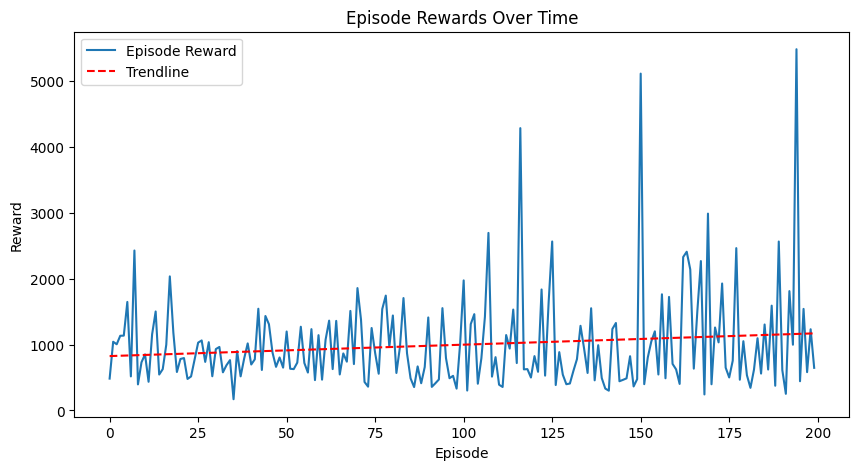

In [3]:
import matplotlib.pyplot as plt

# Plot the episode rewards
plt.figure(figsize=(10, 5))
plt.plot(list_of_episode_rewards, label='Episode Reward')

# Calculate and plot the trendline
x = np.arange(len(list_of_episode_rewards))
z = np.polyfit(x, list_of_episode_rewards, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Time')
plt.legend()
plt.show()


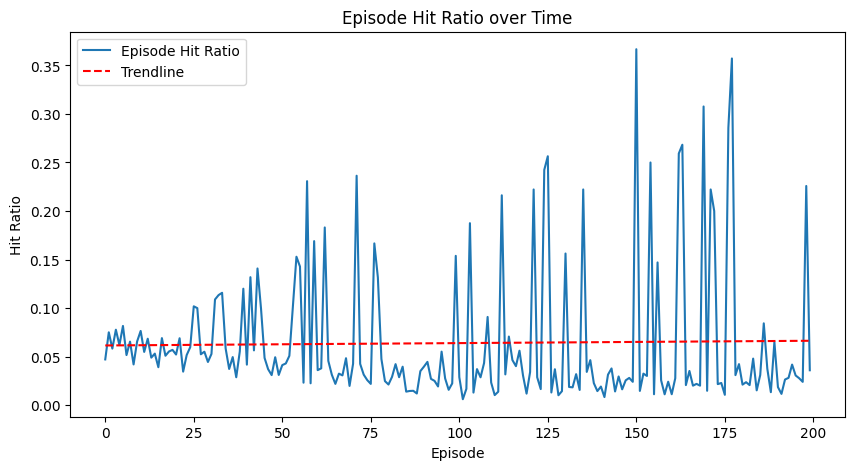

In [4]:
# Plot the episode rewards
plt.figure(figsize=(10, 5))
plt.plot(list_of_hit_ratios, label='Episode Hit Ratio')

# Calculate and plot the trendline
x = np.arange(len(list_of_hit_ratios))
z = np.polyfit(x, list_of_hit_ratios, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Hit Ratio')
plt.title('Episode Hit Ratio over Time')
plt.legend()
plt.show()

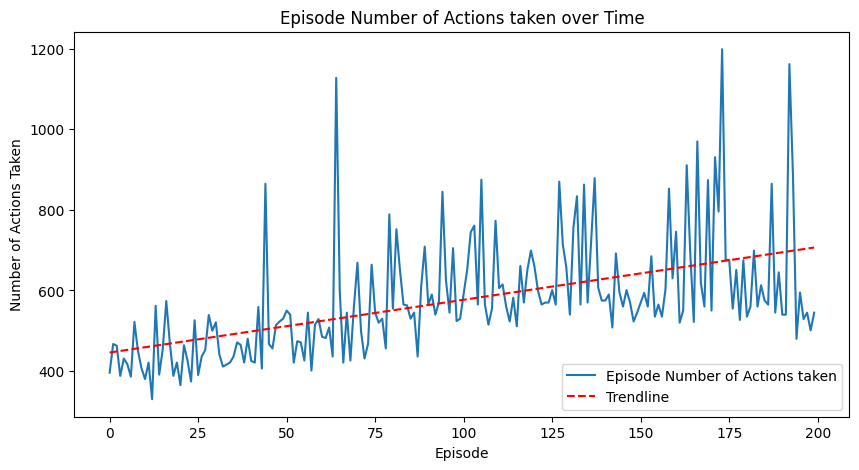

In [5]:
# Plot the episode rewards
plt.figure(figsize=(10, 5))
plt.plot(list_of_actions_taken, label='Episode Number of Actions taken')

# Calculate and plot the trendline
x = np.arange(len(list_of_actions_taken))
z = np.polyfit(x, list_of_actions_taken, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Number of Actions Taken')
plt.title('Episode Number of Actions taken over Time')
plt.legend()
plt.show()